# Assignment2

## Import Necessary Libraries

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report  # Add this line
import warnings

In [4]:
!pip install  scikit-learn

## Dataset Loading 

In [5]:
# Set device (use MPS for Apple Silicon, CUDA for other GPUs)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the CIFAR-10 data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for compatibility with pre-trained models
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cuda
Files already downloaded and verified
Files already downloaded and verified


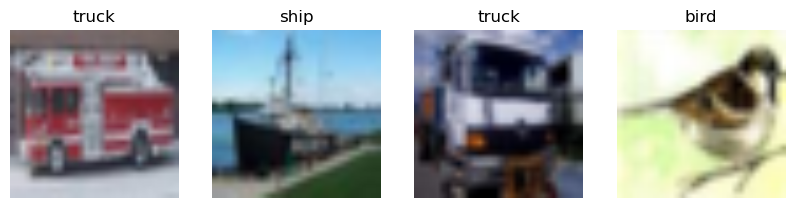

In [6]:
def show_cifar10_examples(dataset, classes, num_images=4):
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(data_loader))
    images = images / 2 + 0.5  # Unnormalize images
    np_images = images.numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(np.transpose(np_images[i], (1, 2, 0)))
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show CIFAR-10 examples
show_cifar10_examples(train_dataset, classes)

In [7]:
def get_data_loaders(batch_size, subset_ratio=0.1):
    # Calculate sizes for train and validation subsets
    train_size = int(subset_ratio * len(train_dataset))
    val_size = int(train_size * 0.2)  # 20% of the training subset as validation set

    # Split dataset into train and validation sets without overlap
    train_subset, val_subset = random_split(train_dataset, [train_size - val_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
    
    return train_loader, val_loader, test_loader

In [8]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to train and validate the model for one epoch
def train_validate_epoch(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_accuracy = 100 * val_correct / val_total
    return train_loss / len(train_loader), train_accuracy, val_loss / len(val_loader), val_accuracy

# Function to plot learning curves
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Training and Validation Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Function to evaluate model on test data and calculate accuracy, precision, recall, F1-score
def evaluate_metrics(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='weighted') * 100
    recall = recall_score(all_labels, all_preds, average='weighted') * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    
    # Print classification report for detailed metrics
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=test_dataset.classes))
    return accuracy, precision, recall, f1

# Function to evaluate model on test data
def evaluate_test_data(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    return 100 * test_correct / test_total

def train_with_early_stopping(model_name, model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\n{model_name} - Epoch {epoch+1}/{num_epochs}")
        
        # Train and validate for one epoch
        train_loss, train_acc, val_loss, val_acc = train_validate_epoch(
            model, train_loader, val_loader, criterion, optimizer, device
        )
        
        # Append results to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print training and validation metrics for this epoch
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        
        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Plot learning curve
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name)
    return model

In [9]:
# Define models
def get_resnet18_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

def get_vgg16_model():
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    return model.to(device)

def get_mobilenet_v2_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    return model.to(device)


Training ResNet18 with batch size 16 and learning rate 0.01

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.18it/s]


Train Loss: 1.4887, Train Accuracy: 57.60%
Val Loss: 0.7174, Val Accuracy: 78.50%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 63/63 [00:09<00:00,  6.45it/s]


Train Loss: 1.2503, Train Accuracy: 67.92%
Val Loss: 0.8234, Val Accuracy: 74.80%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.22it/s]


Train Loss: 1.2661, Train Accuracy: 70.00%
Val Loss: 0.7005, Val Accuracy: 80.30%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.29it/s]


Train Loss: 1.1354, Train Accuracy: 72.54%
Val Loss: 0.8959, Val Accuracy: 75.90%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 63/63 [00:09<00:00,  6.38it/s]


Train Loss: 1.1212, Train Accuracy: 73.10%
Val Loss: 0.6885, Val Accuracy: 81.70%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.13it/s]


Train Loss: 1.2024, Train Accuracy: 72.56%
Val Loss: 0.9735, Val Accuracy: 77.00%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.30it/s]


Train Loss: 1.1455, Train Accuracy: 73.50%
Val Loss: 0.6110, Val Accuracy: 82.70%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s]


Train Loss: 1.1087, Train Accuracy: 74.52%
Val Loss: 1.2772, Val Accuracy: 76.30%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.30it/s]


Train Loss: 1.1381, Train Accuracy: 74.90%
Val Loss: 0.6241, Val Accuracy: 83.60%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.10it/s]

Train Loss: 1.1521, Train Accuracy: 74.82%
Val Loss: 0.7140, Val Accuracy: 82.20%
Early stopping triggered.


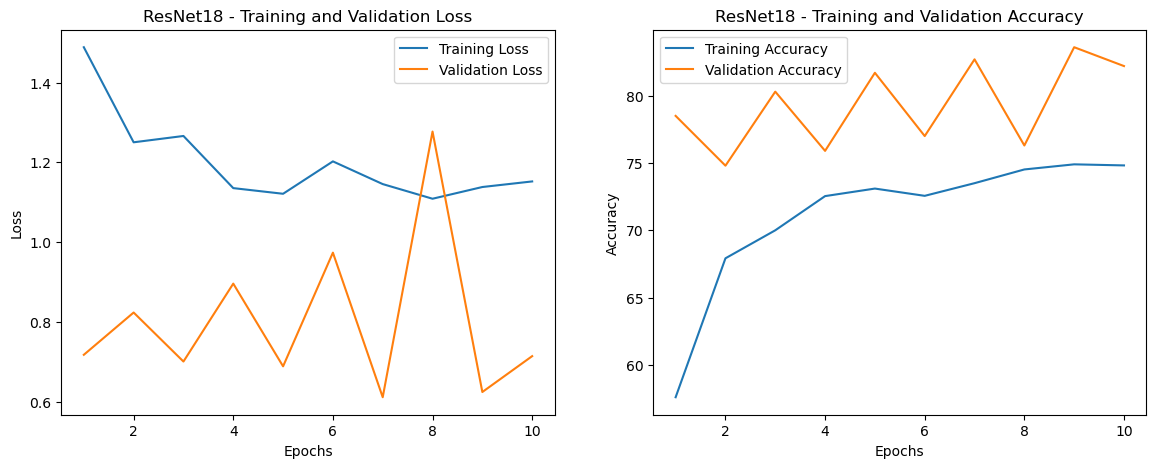

Testing: 100%|██████████| 63/63 [00:10<00:00,  6.10it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.88      0.91      0.89       101
  automobile       0.96      0.83      0.89        94
        bird       0.65      0.90      0.75       107
         cat       0.85      0.58      0.69        95
        deer       0.79      0.74      0.76       118
         dog       0.89      0.67      0.77        98
        frog       0.82      0.87      0.85       103
       horse       0.73      0.95      0.83       101
        ship       0.96      0.89      0.92        79
       truck       0.89      0.88      0.89       104

    accuracy                           0.82      1000
   macro avg       0.84      0.82      0.82      1000
weighted avg       0.84      0.82      0.82      1000

ResNet18 Validation Accuracy: 82.20%

Training ResNet18 with batch size 16 and learning rate 0.001

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.26it/s]


Train Loss: 1.3700, Train Accuracy: 55.02%
Val Loss: 0.7935, Val Accuracy: 76.20%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 63/63 [00:10<00:00,  6.17it/s]


Train Loss: 0.8583, Train Accuracy: 71.94%
Val Loss: 0.6218, Val Accuracy: 80.80%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.60it/s]


Train Loss: 0.7665, Train Accuracy: 74.40%
Val Loss: 0.5798, Val Accuracy: 82.10%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.74it/s]


Train Loss: 0.6971, Train Accuracy: 77.22%
Val Loss: 0.5360, Val Accuracy: 82.30%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.68it/s]


Train Loss: 0.6804, Train Accuracy: 76.70%
Val Loss: 0.5121, Val Accuracy: 83.10%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.49it/s]


Train Loss: 0.6602, Train Accuracy: 76.92%
Val Loss: 0.4886, Val Accuracy: 83.10%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.64it/s]


Train Loss: 0.6309, Train Accuracy: 78.34%
Val Loss: 0.4704, Val Accuracy: 84.70%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.49it/s]


Train Loss: 0.6183, Train Accuracy: 78.12%
Val Loss: 0.4461, Val Accuracy: 84.40%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.60it/s]


Train Loss: 0.6085, Train Accuracy: 79.24%
Val Loss: 0.4478, Val Accuracy: 83.90%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.66it/s]

Train Loss: 0.6179, Train Accuracy: 78.54%
Val Loss: 0.4529, Val Accuracy: 82.80%


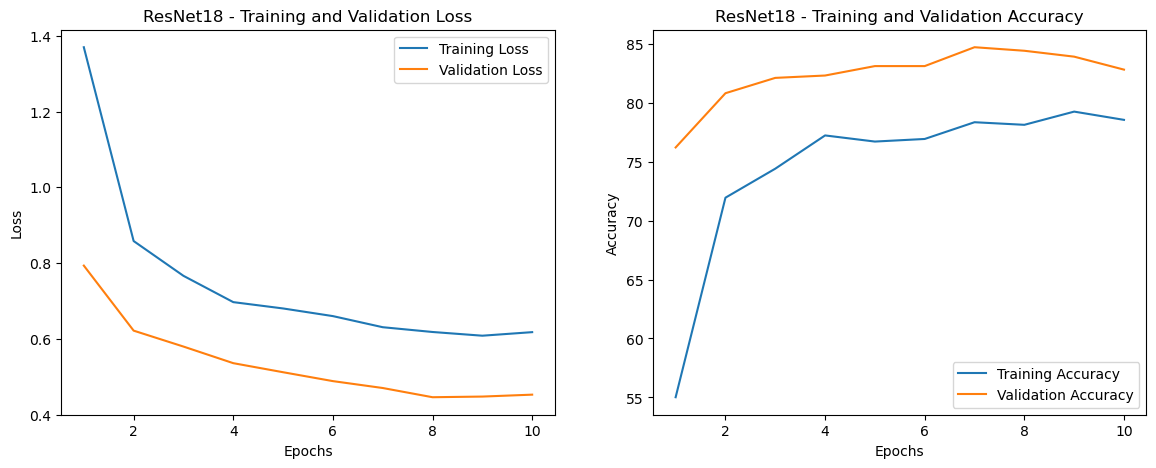

Testing: 100%|██████████| 63/63 [00:08<00:00,  7.60it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.88      0.77      0.82        96
  automobile       0.90      0.94      0.92        99
        bird       0.74      0.92      0.82        99
         cat       0.84      0.45      0.58        94
        deer       0.86      0.74      0.80        90
         dog       0.72      0.90      0.80       117
        frog       0.78      0.89      0.83        99
       horse       0.87      0.89      0.88        98
        ship       0.97      0.79      0.87       105
       truck       0.83      0.95      0.89       103

    accuracy                           0.83      1000
   macro avg       0.84      0.82      0.82      1000
weighted avg       0.84      0.83      0.82      1000

ResNet18 Validation Accuracy: 82.80%

Training ResNet18 with batch size 16 and learning rate 0.0001

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.52it/s]


Train Loss: 2.1447, Train Accuracy: 23.52%
Val Loss: 1.8185, Val Accuracy: 47.70%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.61it/s]


Train Loss: 1.7006, Train Accuracy: 50.66%
Val Loss: 1.4537, Val Accuracy: 63.80%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.63it/s]


Train Loss: 1.4318, Train Accuracy: 61.72%
Val Loss: 1.2398, Val Accuracy: 70.00%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.51it/s]


Train Loss: 1.2698, Train Accuracy: 66.82%
Val Loss: 1.1014, Val Accuracy: 73.60%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.52it/s]


Train Loss: 1.1608, Train Accuracy: 68.70%
Val Loss: 1.0096, Val Accuracy: 74.50%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.64it/s]


Train Loss: 1.0715, Train Accuracy: 70.22%
Val Loss: 0.9232, Val Accuracy: 75.50%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.65it/s]


Train Loss: 1.0123, Train Accuracy: 72.14%
Val Loss: 0.8635, Val Accuracy: 77.10%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.68it/s]


Train Loss: 0.9554, Train Accuracy: 72.68%
Val Loss: 0.8213, Val Accuracy: 77.70%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.63it/s]


Train Loss: 0.9345, Train Accuracy: 72.34%
Val Loss: 0.7874, Val Accuracy: 77.30%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 63/63 [00:08<00:00,  7.49it/s]

Train Loss: 0.8897, Train Accuracy: 73.70%
Val Loss: 0.7607, Val Accuracy: 77.90%


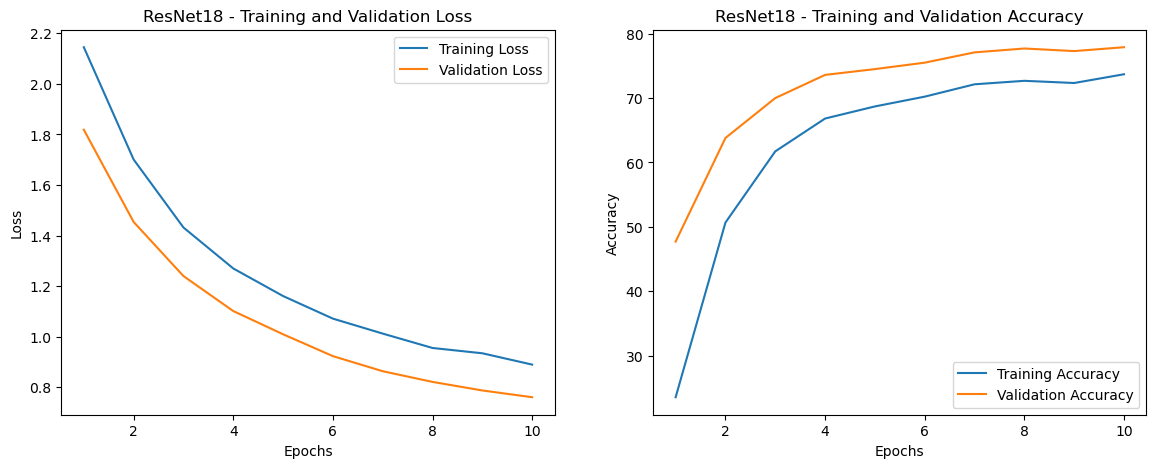

Testing: 100%|██████████| 63/63 [00:08<00:00,  7.59it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.85      0.85      0.85       117
  automobile       0.79      0.90      0.84        92
        bird       0.70      0.56      0.63       101
         cat       0.64      0.66      0.65        96
        deer       0.74      0.73      0.73        89
         dog       0.79      0.71      0.75       102
        frog       0.79      0.82      0.80       114
       horse       0.80      0.85      0.83       100
        ship       0.84      0.89      0.86        99
       truck       0.81      0.82      0.82        90

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

ResNet18 Validation Accuracy: 77.90%

Training ResNet18 with batch size 32 and learning rate 0.01

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Train Loss: 1.2876, Train Accuracy: 60.14%
Val Loss: 0.8050, Val Accuracy: 74.00%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Train Loss: 0.8491, Train Accuracy: 72.92%
Val Loss: 0.6334, Val Accuracy: 79.00%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Train Loss: 0.8621, Train Accuracy: 73.72%
Val Loss: 0.7446, Val Accuracy: 76.70%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Train Loss: 0.8089, Train Accuracy: 74.84%
Val Loss: 0.7280, Val Accuracy: 77.30%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]

Train Loss: 0.7831, Train Accuracy: 75.94%
Val Loss: 0.6443, Val Accuracy: 78.90%
Early stopping triggered.


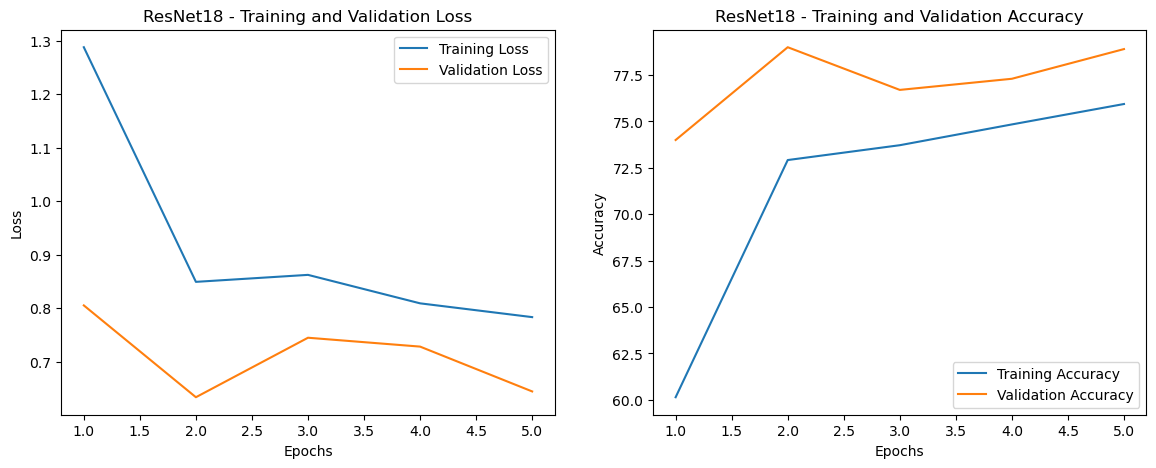

Testing: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.75      0.86      0.80       107
  automobile       0.96      0.87      0.91       108
        bird       0.71      0.65      0.68        77
         cat       0.64      0.87      0.74       106
        deer       0.95      0.52      0.67       118
         dog       0.81      0.77      0.79        97
        frog       0.94      0.81      0.87       105
       horse       0.60      0.97      0.74        93
        ship       1.00      0.56      0.72        77
       truck       0.85      0.96      0.90       112

    accuracy                           0.79      1000
   macro avg       0.82      0.78      0.78      1000
weighted avg       0.82      0.79      0.79      1000

ResNet18 Validation Accuracy: 78.90%

Training ResNet18 with batch size 32 and learning rate 0.001

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Train Loss: 1.3955, Train Accuracy: 55.88%
Val Loss: 0.9056, Val Accuracy: 74.20%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Train Loss: 0.8525, Train Accuracy: 73.72%
Val Loss: 0.7073, Val Accuracy: 77.80%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Train Loss: 0.7446, Train Accuracy: 75.30%
Val Loss: 0.6218, Val Accuracy: 80.40%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Train Loss: 0.6784, Train Accuracy: 77.32%
Val Loss: 0.5858, Val Accuracy: 80.90%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Train Loss: 0.6389, Train Accuracy: 78.36%
Val Loss: 0.5395, Val Accuracy: 82.20%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Train Loss: 0.6046, Train Accuracy: 79.64%
Val Loss: 0.4959, Val Accuracy: 84.50%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Train Loss: 0.5952, Train Accuracy: 79.68%
Val Loss: 0.4876, Val Accuracy: 83.60%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Train Loss: 0.5686, Train Accuracy: 80.22%
Val Loss: 0.4650, Val Accuracy: 84.70%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Train Loss: 0.5582, Train Accuracy: 81.04%
Val Loss: 0.4560, Val Accuracy: 84.80%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Train Loss: 0.5413, Train Accuracy: 80.90%
Val Loss: 0.4398, Val Accuracy: 84.80%


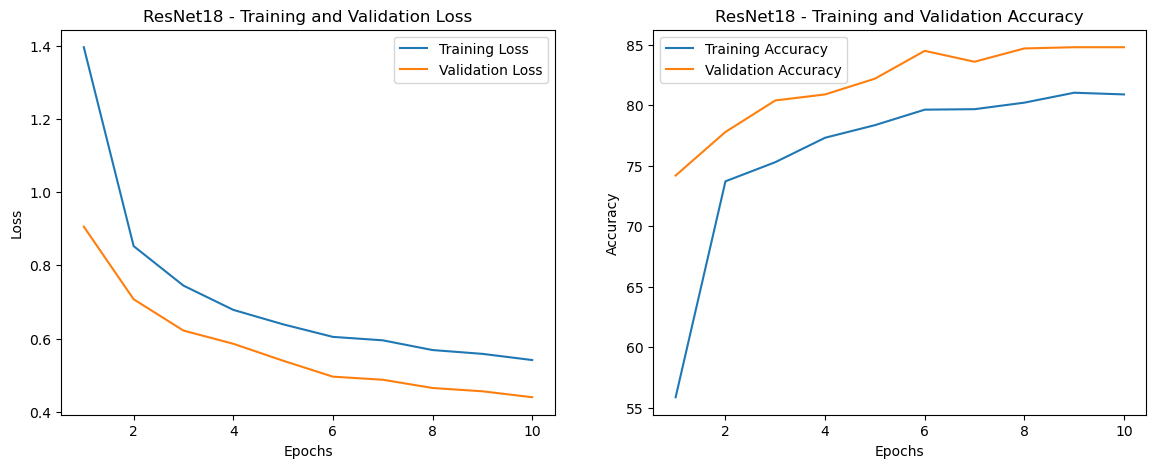

Testing: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.89      0.93      0.91        97
  automobile       0.94      0.91      0.92       119
        bird       0.88      0.75      0.81        99
         cat       0.89      0.69      0.78        96
        deer       0.77      0.80      0.79        92
         dog       0.71      0.92      0.80       102
        frog       0.85      0.85      0.85       100
       horse       0.88      0.83      0.86       101
        ship       0.88      0.82      0.85        91
       truck       0.84      0.95      0.89       103

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

ResNet18 Validation Accuracy: 84.80%

Training ResNet18 with batch size 32 and learning rate 0.0001

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Train Loss: 2.1940, Train Accuracy: 20.40%
Val Loss: 1.9746, Val Accuracy: 35.50%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Train Loss: 1.8339, Train Accuracy: 43.88%
Val Loss: 1.6632, Val Accuracy: 53.10%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Train Loss: 1.5821, Train Accuracy: 56.30%
Val Loss: 1.4535, Val Accuracy: 59.80%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Train Loss: 1.4054, Train Accuracy: 63.98%
Val Loss: 1.2899, Val Accuracy: 66.30%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Train Loss: 1.2687, Train Accuracy: 66.52%
Val Loss: 1.1924, Val Accuracy: 69.10%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Train Loss: 1.1755, Train Accuracy: 69.28%
Val Loss: 1.0830, Val Accuracy: 71.20%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Train Loss: 1.1014, Train Accuracy: 70.94%
Val Loss: 1.0169, Val Accuracy: 72.80%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Train Loss: 1.0430, Train Accuracy: 71.68%
Val Loss: 0.9734, Val Accuracy: 74.50%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Train Loss: 0.9983, Train Accuracy: 72.88%
Val Loss: 0.9242, Val Accuracy: 75.00%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]

Train Loss: 0.9534, Train Accuracy: 73.32%
Val Loss: 0.8827, Val Accuracy: 76.00%


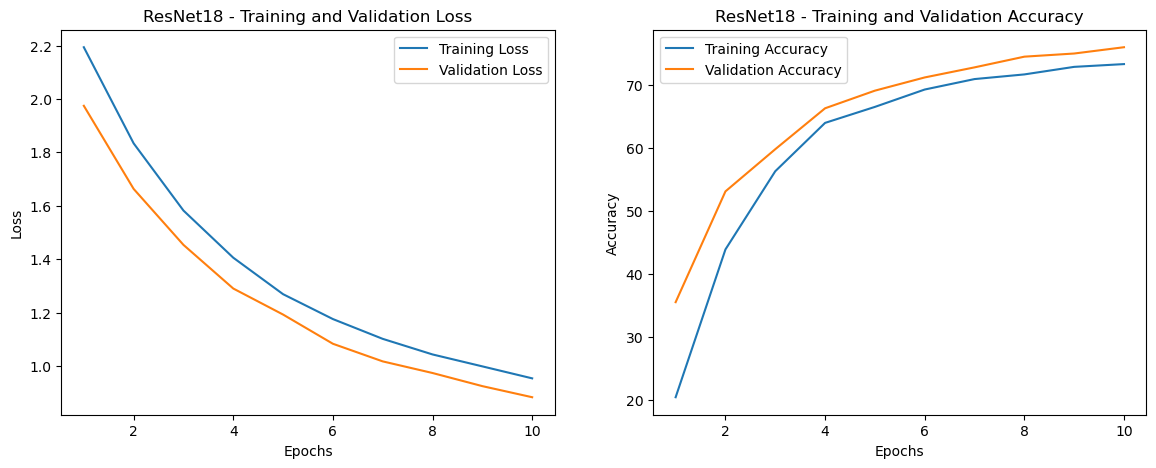

Testing: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.81      0.72      0.76       101
  automobile       0.88      0.88      0.88       103
        bird       0.77      0.64      0.70       113
         cat       0.60      0.64      0.62        96
        deer       0.79      0.74      0.76       112
         dog       0.68      0.70      0.69        89
        frog       0.75      0.81      0.78        85
       horse       0.75      0.81      0.78        89
        ship       0.76      0.81      0.78       105
       truck       0.81      0.86      0.83       107

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

ResNet18 Validation Accuracy: 76.00%

Training ResNet18 with batch size 64 and learning rate 0.01

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 1.3535, Train Accuracy: 58.56%
Val Loss: 0.6713, Val Accuracy: 77.70%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.7198, Train Accuracy: 75.50%
Val Loss: 0.6176, Val Accuracy: 78.80%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


Train Loss: 0.6732, Train Accuracy: 77.18%
Val Loss: 0.6733, Val Accuracy: 79.00%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.6506, Train Accuracy: 78.20%
Val Loss: 0.5753, Val Accuracy: 78.40%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.5822, Train Accuracy: 79.96%
Val Loss: 0.5675, Val Accuracy: 80.60%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.5747, Train Accuracy: 80.04%
Val Loss: 0.4529, Val Accuracy: 84.90%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.5829, Train Accuracy: 80.38%
Val Loss: 0.6100, Val Accuracy: 79.10%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.6157, Train Accuracy: 80.48%
Val Loss: 0.5120, Val Accuracy: 81.30%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.5700, Train Accuracy: 80.84%
Val Loss: 0.3701, Val Accuracy: 86.60%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]

Train Loss: 0.5505, Train Accuracy: 81.82%
Val Loss: 0.4519, Val Accuracy: 84.60%


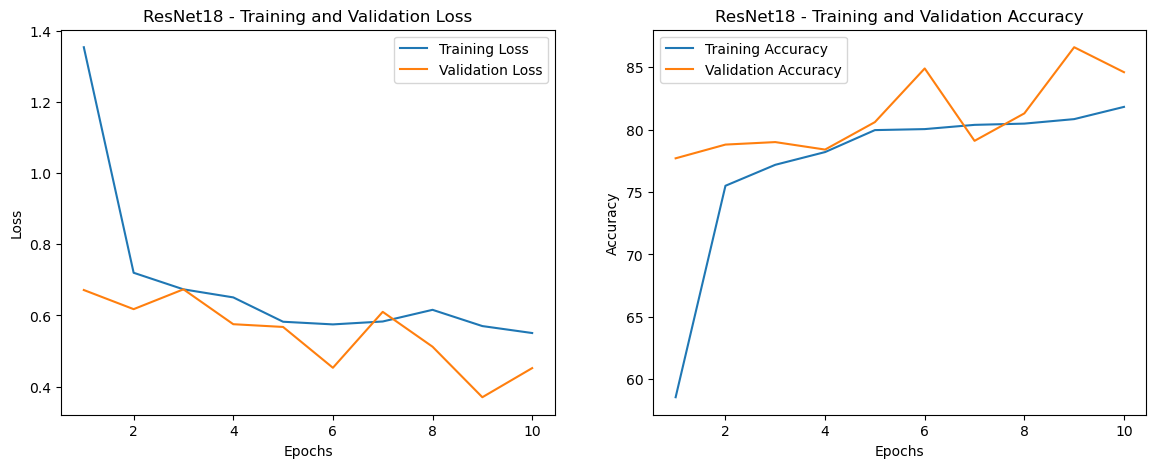

Testing: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.85      0.95      0.90       108
  automobile       1.00      0.88      0.94        93
        bird       1.00      0.60      0.75        92
         cat       0.90      0.61      0.73       105
        deer       0.82      0.82      0.82       118
         dog       0.62      0.95      0.75        87
        frog       0.88      0.93      0.91       107
       horse       0.88      0.79      0.83       101
        ship       0.91      0.96      0.93       101
       truck       0.79      0.97      0.87        88

    accuracy                           0.85      1000
   macro avg       0.87      0.85      0.84      1000
weighted avg       0.87      0.85      0.84      1000

ResNet18 Validation Accuracy: 84.60%

Training ResNet18 with batch size 64 and learning rate 0.001

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


Train Loss: 1.5973, Train Accuracy: 49.86%
Val Loss: 1.0543, Val Accuracy: 71.90%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


Train Loss: 0.9505, Train Accuracy: 72.56%
Val Loss: 0.7807, Val Accuracy: 77.90%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Train Loss: 0.7885, Train Accuracy: 75.78%
Val Loss: 0.6770, Val Accuracy: 78.90%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.7309, Train Accuracy: 77.52%
Val Loss: 0.6334, Val Accuracy: 79.50%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


Train Loss: 0.6706, Train Accuracy: 78.28%
Val Loss: 0.5867, Val Accuracy: 81.70%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.6561, Train Accuracy: 78.68%
Val Loss: 0.5412, Val Accuracy: 82.20%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.6110, Train Accuracy: 79.98%
Val Loss: 0.5313, Val Accuracy: 82.40%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


Train Loss: 0.5812, Train Accuracy: 80.98%
Val Loss: 0.4929, Val Accuracy: 82.70%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Train Loss: 0.5678, Train Accuracy: 81.04%
Val Loss: 0.4971, Val Accuracy: 83.00%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

Train Loss: 0.5613, Train Accuracy: 81.36%
Val Loss: 0.4832, Val Accuracy: 83.00%


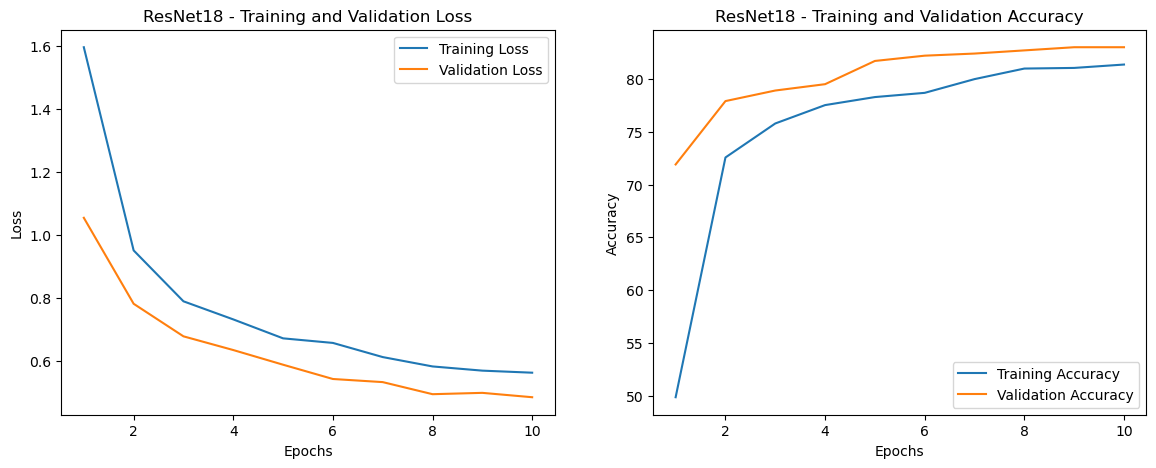

Testing: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]



Classification Report:
               precision    recall  f1-score   support

    airplane       0.89      0.83      0.86       109
  automobile       0.75      0.96      0.84        93
        bird       0.78      0.82      0.80        96
         cat       0.74      0.67      0.71        95
        deer       0.76      0.86      0.81       106
         dog       0.89      0.79      0.84       114
        frog       0.86      0.87      0.86        92
       horse       0.86      0.79      0.82        95
        ship       0.92      0.84      0.88       105
       truck       0.87      0.88      0.88        95

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

ResNet18 Validation Accuracy: 83.00%

Training ResNet18 with batch size 64 and learning rate 0.0001

ResNet18 - Epoch 1/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


Train Loss: 2.3383, Train Accuracy: 12.82%
Val Loss: 2.1669, Val Accuracy: 21.60%

ResNet18 - Epoch 2/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


Train Loss: 2.0540, Train Accuracy: 29.48%
Val Loss: 1.9062, Val Accuracy: 39.80%

ResNet18 - Epoch 3/10


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


Train Loss: 1.8256, Train Accuracy: 43.10%
Val Loss: 1.7093, Val Accuracy: 51.30%

ResNet18 - Epoch 4/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


Train Loss: 1.6427, Train Accuracy: 54.70%
Val Loss: 1.5421, Val Accuracy: 58.50%

ResNet18 - Epoch 5/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


Train Loss: 1.5014, Train Accuracy: 61.62%
Val Loss: 1.4110, Val Accuracy: 62.70%

ResNet18 - Epoch 6/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


Train Loss: 1.3878, Train Accuracy: 64.98%
Val Loss: 1.3054, Val Accuracy: 67.70%

ResNet18 - Epoch 7/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


Train Loss: 1.2910, Train Accuracy: 68.10%
Val Loss: 1.2216, Val Accuracy: 69.90%

ResNet18 - Epoch 8/10


Validation: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


Train Loss: 1.2093, Train Accuracy: 70.02%
Val Loss: 1.1458, Val Accuracy: 71.70%

ResNet18 - Epoch 9/10


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


Train Loss: 1.1524, Train Accuracy: 71.28%
Val Loss: 1.0846, Val Accuracy: 72.70%

ResNet18 - Epoch 10/10


Validation: 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Train Loss: 1.0925, Train Accuracy: 72.34%
Val Loss: 1.0350, Val Accuracy: 73.60%


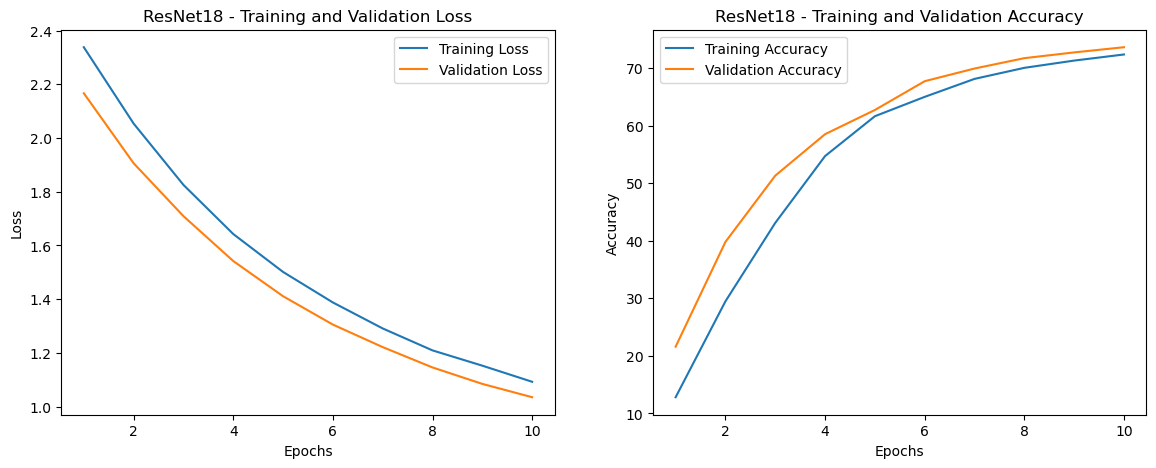

Testing: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


Classification Report:
               precision    recall  f1-score   support

    airplane       0.72      0.74      0.73       104
  automobile       0.84      0.83      0.83        88
        bird       0.75      0.55      0.63        84
         cat       0.68      0.63      0.65       122
        deer       0.65      0.67      0.66        93
         dog       0.72      0.72      0.72        94
        frog       0.68      0.83      0.75        93
       horse       0.77      0.77      0.77       112
        ship       0.71      0.77      0.74        92
       truck       0.85      0.84      0.85       118

    accuracy                           0.74      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.74      0.73      1000

ResNet18 Validation Accuracy: 73.60%


In [10]:
# Grid search for ResNet18
batch_sizes = [16, 32, 64]
learning_rates = [0.01, 0.001, 0.0001]
num_epochs = 10
best_resnet_val_acc = 0
best_resnet_model = None
best_params = {'batch_size': None, 'learning_rate': None}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining ResNet18 with batch size {batch_size} and learning rate {lr}")
        
        # Prepare data loaders
        train_loader, val_loader, test_loader = get_data_loaders(batch_size=batch_size)
        
        # Initialize model, criterion, and optimizer
        resnet18_model = get_resnet18_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(resnet18_model.fc.parameters(), lr=lr)
        
        # Train with early stopping and evaluate on validation set
        resnet18_model = train_with_early_stopping("ResNet18", resnet18_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
        val_acc = evaluate_metrics(resnet18_model, val_loader)[0]  # Only taking the accuracy from validation metrics
        print(f"ResNet18 Validation Accuracy: {val_acc:.2f}%")
        
        # Check if this configuration is the best so far based on validation accuracy
        if val_acc > best_resnet_val_acc:
            best_resnet_val_acc = val_acc
            best_resnet_model = resnet18_model
            best_params['batch_size'] = batch_size
            best_params['learning_rate'] = lr

In [11]:
# Final evaluation of the best ResNet18 model on the test set
print(f"\nBest ResNet18 Model - Batch Size: {best_params['batch_size']}, Learning Rate: {best_params['learning_rate']}")
best_resnet_test_metrics = evaluate_metrics(best_resnet_model, test_loader)
print(f"Best ResNet18 Test Metrics - Accuracy: {best_resnet_test_metrics[0]:.2f}%, Precision: {best_resnet_test_metrics[1]:.2f}%, Recall: {best_resnet_test_metrics[2]:.2f}%, F1 Score: {best_resnet_test_metrics[3]:.2f}%")

# Evaluate VGG16 model


Best ResNet18 Model - Batch Size: 32, Learning Rate: 0.001


Testing: 100%|██████████| 157/157 [00:12<00:00, 12.56it/s]


Classification Report:
               precision    recall  f1-score   support

    airplane       0.77      0.81      0.79      1000
  automobile       0.87      0.86      0.86      1000
        bird       0.77      0.68      0.72      1000
         cat       0.72      0.50      0.59      1000
        deer       0.75      0.70      0.72      1000
         dog       0.60      0.83      0.70      1000
        frog       0.82      0.81      0.81      1000
       horse       0.80      0.78      0.79      1000
        ship       0.83      0.83      0.83      1000
       truck       0.80      0.88      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Best ResNet18 Test Metrics - Accuracy: 76.83%, Precision: 77.30%, Recall: 76.83%, F1 Score: 76.62%



Training and Evaluating VGG16...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\qinji/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:22<00:00, 24.4MB/s] 



VGG16 - Epoch 1/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


Train Loss: 1.0099, Train Accuracy: 64.42%
Val Loss: 0.6404, Val Accuracy: 76.60%

VGG16 - Epoch 2/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.06it/s]


Train Loss: 0.7513, Train Accuracy: 72.50%
Val Loss: 0.5536, Val Accuracy: 80.50%

VGG16 - Epoch 3/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Train Loss: 0.6873, Train Accuracy: 74.82%
Val Loss: 0.5120, Val Accuracy: 82.80%

VGG16 - Epoch 4/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Train Loss: 0.6522, Train Accuracy: 76.44%
Val Loss: 0.4842, Val Accuracy: 82.70%

VGG16 - Epoch 5/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


Train Loss: 0.6295, Train Accuracy: 77.40%
Val Loss: 0.4337, Val Accuracy: 85.60%

VGG16 - Epoch 6/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Train Loss: 0.6090, Train Accuracy: 78.02%
Val Loss: 0.4071, Val Accuracy: 86.70%

VGG16 - Epoch 7/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Train Loss: 0.6024, Train Accuracy: 78.54%
Val Loss: 0.3996, Val Accuracy: 86.30%

VGG16 - Epoch 8/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Train Loss: 0.6001, Train Accuracy: 78.30%
Val Loss: 0.3553, Val Accuracy: 89.50%

VGG16 - Epoch 9/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Train Loss: 0.6020, Train Accuracy: 78.16%
Val Loss: 0.3557, Val Accuracy: 88.50%

VGG16 - Epoch 10/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]

Train Loss: 0.5693, Train Accuracy: 79.62%
Val Loss: 0.3343, Val Accuracy: 89.10%


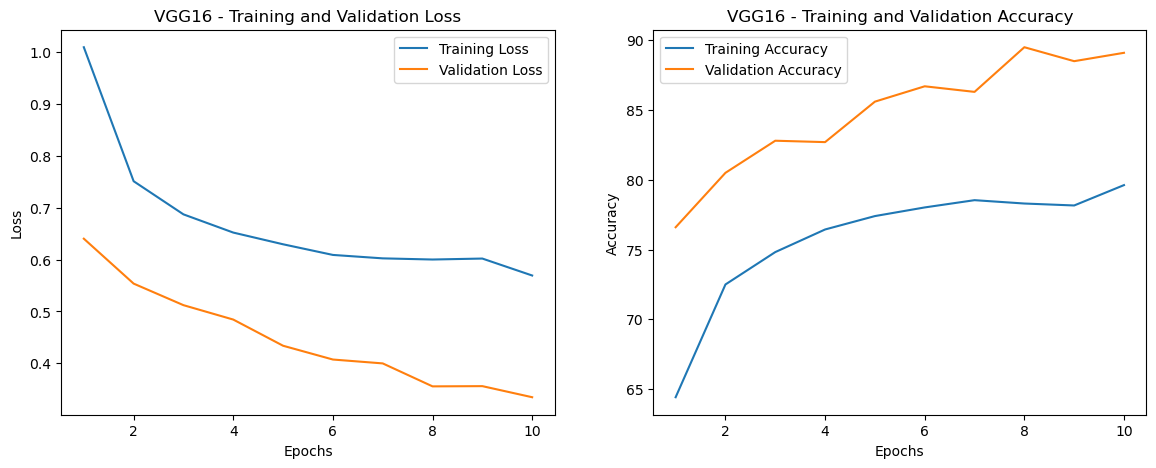

Testing: 100%|██████████| 313/313 [00:19<00:00, 16.42it/s]


Classification Report:
               precision    recall  f1-score   support

    airplane       0.73      0.84      0.78      1000
  automobile       0.86      0.86      0.86      1000
        bird       0.80      0.59      0.68      1000
         cat       0.59      0.73      0.65      1000
        deer       0.67      0.77      0.71      1000
         dog       0.78      0.72      0.75      1000
        frog       0.80      0.80      0.80      1000
       horse       0.82      0.77      0.79      1000
        ship       0.89      0.76      0.82      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

VGG16 Test Metrics - Accuracy: 76.88%, Precision: 77.86%, Recall: 76.88%, F1 Score: 76.97%


In [12]:
# Train and evaluate each model
batch_size = 32
num_epochs = 10
train_loader, val_loader, test_loader = get_data_loaders(batch_size=batch_size)

# Evaluate VGG16 model
print("\nTraining and Evaluating VGG16...")
vgg16_model = get_vgg16_model()
optimizer = optim.Adam(vgg16_model.classifier[-1].parameters(), lr=0.001)
vgg16_model = train_with_early_stopping("VGG16", vgg16_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
vgg16_test_metrics = evaluate_metrics(vgg16_model, test_loader)
print(f"VGG16 Test Metrics - Accuracy: {vgg16_test_metrics[0]:.2f}%, Precision: {vgg16_test_metrics[1]:.2f}%, Recall: {vgg16_test_metrics[2]:.2f}%, F1 Score: {vgg16_test_metrics[3]:.2f}%")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\qinji/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth



Training and Evaluating MobileNetV2...


100%|██████████| 13.6M/13.6M [00:02<00:00, 4.88MB/s]



MobileNetV2 - Epoch 1/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


Train Loss: 1.5230, Train Accuracy: 55.40%
Val Loss: 1.0026, Val Accuracy: 74.10%

MobileNetV2 - Epoch 2/10


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


Train Loss: 1.0162, Train Accuracy: 69.02%
Val Loss: 0.8025, Val Accuracy: 75.40%

MobileNetV2 - Epoch 3/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


Train Loss: 0.8924, Train Accuracy: 71.96%
Val Loss: 0.7022, Val Accuracy: 79.00%

MobileNetV2 - Epoch 4/10


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.20it/s]


Train Loss: 0.8302, Train Accuracy: 72.76%
Val Loss: 0.6537, Val Accuracy: 80.40%

MobileNetV2 - Epoch 5/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Train Loss: 0.7761, Train Accuracy: 74.56%
Val Loss: 0.6012, Val Accuracy: 82.40%

MobileNetV2 - Epoch 6/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


Train Loss: 0.7383, Train Accuracy: 75.76%
Val Loss: 0.5565, Val Accuracy: 83.60%

MobileNetV2 - Epoch 7/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Train Loss: 0.7157, Train Accuracy: 76.68%
Val Loss: 0.5394, Val Accuracy: 84.60%

MobileNetV2 - Epoch 8/10


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.20it/s]


Train Loss: 0.6906, Train Accuracy: 77.04%
Val Loss: 0.5161, Val Accuracy: 84.50%

MobileNetV2 - Epoch 9/10


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.20it/s]


Train Loss: 0.6746, Train Accuracy: 77.74%
Val Loss: 0.4890, Val Accuracy: 84.50%

MobileNetV2 - Epoch 10/10


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.20it/s]

Train Loss: 0.6615, Train Accuracy: 78.18%
Val Loss: 0.4805, Val Accuracy: 85.60%


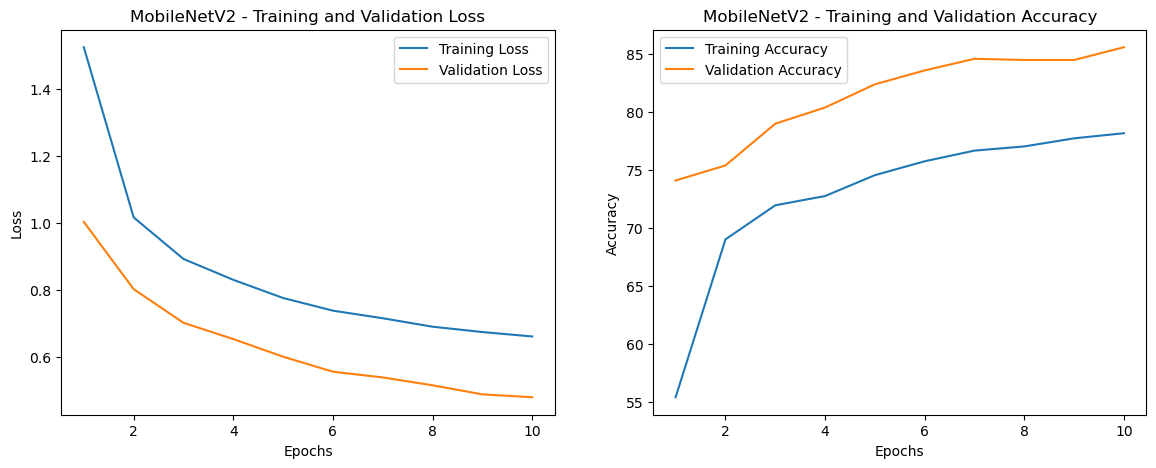

Testing: 100%|██████████| 313/313 [00:13<00:00, 23.33it/s]


Classification Report:
               precision    recall  f1-score   support

    airplane       0.76      0.77      0.77      1000
  automobile       0.82      0.88      0.85      1000
        bird       0.68      0.70      0.69      1000
         cat       0.59      0.56      0.57      1000
        deer       0.69      0.73      0.71      1000
         dog       0.68      0.68      0.68      1000
        frog       0.78      0.78      0.78      1000
       horse       0.77      0.76      0.76      1000
        ship       0.82      0.79      0.81      1000
       truck       0.88      0.80      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

MobileNetV2 Test Metrics - Accuracy: 74.55%, Precision: 74.63%, Recall: 74.55%, F1 Score: 74.55%


In [13]:
# Evaluate MobileNetV2 model
print("\nTraining and Evaluating MobileNetV2...")
mobilenet_v2_model = get_mobilenet_v2_model()
optimizer = optim.Adam(mobilenet_v2_model.classifier[-1].parameters(), lr=0.001)
mobilenet_v2_model = train_with_early_stopping("MobileNetV2", mobilenet_v2_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
mobilenet_v2_test_metrics = evaluate_metrics(mobilenet_v2_model, test_loader)
print(f"MobileNetV2 Test Metrics - Accuracy: {mobilenet_v2_test_metrics[0]:.2f}%, Precision: {mobilenet_v2_test_metrics[1]:.2f}%, Recall: {mobilenet_v2_test_metrics[2]:.2f}%, F1 Score: {mobilenet_v2_test_metrics[3]:.2f}%")


Model Comparison Metrics:
            Model  Accuracy (%)  Precision (%)  Recall (%)  F1 Score (%)
0  Best ResNet18         76.83      77.303724       76.83     76.621483
1          VGG16         76.88      77.856105       76.88     76.970750
2    MobileNetV2         74.55      74.627250       74.55     74.548987


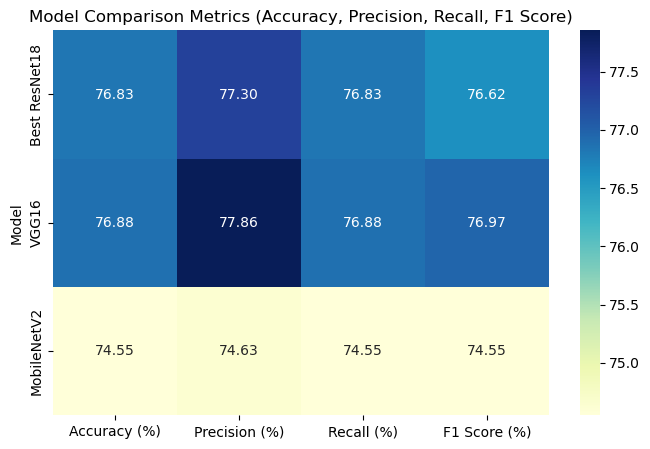

In [14]:
# Collect metrics for comparison
model_comparison = {
    "Model": ["Best ResNet18", "VGG16", "MobileNetV2"],
    "Accuracy (%)": [best_resnet_test_metrics[0], vgg16_test_metrics[0], mobilenet_v2_test_metrics[0]],
    "Precision (%)": [best_resnet_test_metrics[1], vgg16_test_metrics[1], mobilenet_v2_test_metrics[1]],
    "Recall (%)": [best_resnet_test_metrics[2], vgg16_test_metrics[2], mobilenet_v2_test_metrics[2]],
    "F1 Score (%)": [best_resnet_test_metrics[3], vgg16_test_metrics[3], mobilenet_v2_test_metrics[3]]
}

# Create a DataFrame for the comparison metrics and display as heatmap
df_comparison = pd.DataFrame(model_comparison)
print("\nModel Comparison Metrics:\n", df_comparison)

# Plot a heatmap for the comparison metrics
plt.figure(figsize=(8, 5))
sns.heatmap(df_comparison.set_index("Model"), annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Model Comparison Metrics (Accuracy, Precision, Recall, F1 Score)")
plt.show()

In [ ]:
# Function to calculate per-class accuracy
def calculate_per_class_accuracy(model, data_loader, device, num_classes=10):
    model.eval()
    correct_per_class = torch.zeros(num_classes)
    total_per_class = torch.zeros(num_classes)
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Update counts
            for i in range(num_classes):
                class_mask = (labels == i)
                correct_per_class[i] += (predicted[class_mask] == i).sum().item()
                total_per_class[i] += class_mask.sum().item()
                
    per_class_accuracy = (correct_per_class / total_per_class * 100).numpy()
    return per_class_accuracy

# Function to plot per-class accuracy heat map
def plot_per_class_accuracy_heatmap(per_class_accuracy, model_name, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(per_class_accuracy.reshape(1, -1), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True,
                xticklabels=class_names, yticklabels=[model_name])
    plt.xlabel("Classes")
    plt.ylabel("Model")
    plt.title(f"Per-Class Accuracy for {model_name}")
    plt.show()

# Assuming `test_loader` is your DataLoader for test data
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate and plot for ResNet18
resnet18_per_class_accuracy = calculate_per_class_accuracy(resnet18_model, test_loader, device)
plot_per_class_accuracy_heatmap(resnet18_per_class_accuracy, "ResNet18", class_names)

# Calculate and plot for VGG16
vgg16_per_class_accuracy = calculate_per_class_accuracy(vgg16_model, test_loader, device)
plot_per_class_accuracy_heatmap(vgg16_per_class_accuracy, "VGG16", class_names)

# Calculate and plot for MobileNetV2
mobilenetv2_per_class_accuracy = calculate_per_class_accuracy(mobilenetv2_model, test_loader, device)
plot_per_class_accuracy_heatmap(mobilenetv2_per_class_accuracy, "MobileNetV2", class_names)